In [1]:
import os
import shutil
import pandas as pd
import tensorflow as tf
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split

In [2]:
skin_cancer = 'dataset/Skin_Cancer_Dataset'
normal_skin = 'dataset/normal'
results = 'dataset/result'

os.makedirs(results, exist_ok=True)

labels = ['Basal Cell Carcinoma', 'Melanoma',
          'Squamous Cell Carcinoma', 'Normal']
for label in labels:
  os.makedirs(os.path.join(results, label), exist_ok=True)

for label in labels[:-1]:
  label_path = os.path.join(skin_cancer, label)
  if os.path.exists(label_path):
    for file in os.listdir(label_path):
      shutil.copy(os.path.join(label_path, file), os.path.join(results, label))

for file in os.listdir(normal_skin):
  shutil.copy(os.path.join(normal_skin, file), os.path.join(results, 'Normal'))

In [3]:
def get_class_counts(directory, labels):
    class_counts = {}
    for label in labels:
        class_dir = os.path.join(directory, label)
        if os.path.exists(class_dir):
            class_counts[label] = len([f for f in os.listdir(
                class_dir) if f.endswith(('png', 'jpg', 'jpeg', 'JPG'))])
        else:
            class_counts[label] = 0
    return class_counts

In [4]:
from PIL import Image


def clean_data(directory):
  for label in os.listdir(directory):
    label_path = os.path.join(directory, label)
    if file in os.listdir(label_path):
      file_path = os.path.join(label_path, file)
      try:
        img = Image.open(file_path)
        img.verify()
        img = Image.open(file_path)
        img.load()
      except Exception as e:
        print(f"Delete: {file_path}, Error: {e}")
        os.remove(file_path)


clean_data(results)

In [5]:
def split_data(source, destination, split_ratios, labels):
    train = os.path.join(destination, 'train')
    test = os.path.join(destination, 'test')
    val = os.path.join(destination, 'val')

    os.makedirs(train, exist_ok=True)
    os.makedirs(test, exist_ok=True)
    os.makedirs(val, exist_ok=True)

    for label in labels:
        label_path = os.path.join(source, label)
        files = os.listdir(label_path)

        train_files, temp_files = train_test_split(
            files, test_size=(1 - split_ratios[0]), random_state=42)
        test_files, val_files = train_test_split(temp_files, test_size=(
            split_ratios[2] / sum(split_ratios[1:])), random_state=42)

        for phase, phase_files in zip(['train', 'test', 'val'], [train_files, test_files, val_files]):
            phase_dir = os.path.join(destination, phase, label)
            os.makedirs(phase_dir, exist_ok=True)
            for file in phase_files:
                shutil.copy(os.path.join(label_path, file),
                            os.path.join(phase_dir, file))

In [6]:
# def get_class_counts(directory, labels):
#     class_counts = {}
#     for label in labels:
#         class_dir = os.path.join(directory, label)
#         if os.path.exists(class_dir):
#             class_counts[label] = len([f for f in os.listdir(class_dir)
#                                       if f.endswith(('.png', '.jpg', '.jpeg', '.JPG'))])
#     return class_counts

In [7]:
# dataset_path = "./dataset/result"
# base_dir = "./dataset"

In [8]:
def augment_to_target_count(directory, labels, target_count):
    image_gen = ImageDataGenerator(
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    class_counts = get_class_counts(directory, labels)
    
    for label in labels:
        current_count = class_counts[label]
        if current_count < target_count:
            needed_images = target_count - current_count
            class_dir = os.path.join(directory, label)
            existing_files = [f for f in os.listdir(class_dir) if f.endswith(('png', 'jpg', 'jpeg', 'JPG'))]
            generated_count = 0

            while generated_count < needed_images:
                img_name = np.random.choice(existing_files)
                img_path = os.path.join(class_dir, img_name)

                img = load_img(img_path)
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)

                aug_iter = image_gen.flow(
                    x, 
                    batch_size=1,
                    save_to_dir=class_dir,
                    save_prefix=f'aug_{generated_count}',
                    save_format='jpg'
                )

                next(aug_iter)
                generated_count += 1
                if generated_count % 10 == 0:
                    print(f"Generated {generated_count}/{needed_images} images for {label}")

In [9]:
# Main Code
skin_cancer = 'dataset/Skin_Cancer_Dataset'
normal_skin = 'dataset/normal'
results = 'dataset/result'
split_dir = './dataset/split'
split_ratios = [0.7, 0.2, 0.1]
labels = ['Basal Cell Carcinoma', 'Melanoma',
          'Squamous Cell Carcinoma', 'Normal']

os.makedirs(results, exist_ok=True)

In [10]:
for label in labels:
    os.makedirs(os.path.join(results, label), exist_ok=True)

for label in labels[:-1]:
    label_path = os.path.join(skin_cancer, label)
    if os.path.exists(label_path):
        for file in os.listdir(label_path):
            shutil.copy(os.path.join(label_path, file),
                        os.path.join(results, label))

for file in os.listdir(normal_skin):
    shutil.copy(os.path.join(normal_skin, file),
                os.path.join(results, 'Normal'))

# Clean data
clean_data(results)

# Split data
split_data(results, split_dir, split_ratios, labels)

# Augment data for train and val
train_dir = os.path.join(split_dir, 'train')
val_dir = os.path.join(split_dir, 'val')

augment_to_target_count(train_dir, labels, target_count=1000)
augment_to_target_count(val_dir, labels, target_count=300)

In [11]:
# import cv2
# import numpy as np

# def load_existing_dataset(dataset_path, img_size):
#   data = []
#   target = []
#   class_names = sorted(os.listdir(dataset_path))  # Get sorted class names
#   class_mapping = {class_name: i for i, class_name in enumerate(class_names)}

#   for class_name in class_names:
#     class_path = os.path.join(dataset_path, class_name)
#     for img_filename in os.listdir(class_path):
#       img_path = os.path.join(class_path, img_filename)
#       image = cv2.imread(img_path)
#       image = cv2.resize(image, img_size, interpolation=cv2.INTER_LINEAR)
#       data.append(image)
#       target.append(class_mapping[class_name])

#   return np.array(data), np.array(target)


# img_size = (224, 224)  # Adjust as needed

# train_data, train_target = load_existing_dataset(dataset_path, img_size)

# np.save(os.path.join(base_dir, "trainData.npy"), train_data)
# np.save(os.path.join(base_dir, "trainTarget.npy"), train_target)

# print("Dataset loaded and saved successfully!")

In [12]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# import numpy as np


# def augment_to_balanced(train_dir, labels):
#   image_gen = ImageDataGenerator(
#       rotation_range=45,
#       width_shift_range=0.2,
#       height_shift_range=0.2,
#       shear_range=0.2,
#       zoom_range=0.2,
#       horizontal_flip=True,
#       fill_mode='nearest'
#   )

#   class_counts = get_class_count(train_dir, labels)
#   max_count = max(class_counts.values())

#   print("Current class distribution:")
#   for label, count in class_counts.items():
#     print(f"{label}: {count}")
#   print(f"\nTarget count per class: {max_count}")

#   # Augmentasi untuk setiap kelas
#   for label in labels:
#       current_count = class_counts[label]
#       if current_count < max_count:
#           needed_images = max_count - current_count
#           class_dir = os.path.join(train_dir, label)

#           print(f"\nProcessing {label}")
#           print(f"Need to generate {needed_images} more images")

#           existing_files = [f for f in os.listdir(class_dir)
#                             if f.endswith(('.png', '.jpg', '.jpeg', '.JPG'))]

#           generated_count = 0
#           while generated_count < needed_images:
#               img_name = np.random.choice(existing_files)
#               img_path = os.path.join(class_dir, img_name)

#               img = load_img(img_path)
#               x = img_to_array(img)
#               x = np.expand_dims(x, axis=0)

#               aug_iter = image_gen.flow(
#                   x,
#                   batch_size=1,
#                   save_to_dir=class_dir,
#                   save_prefix=f'aug_{generated_count}',
#                   save_format='jpg'
#               )

#               next(aug_iter)
#               generated_count += 1
#               if generated_count % 10 == 0:
#                   print(f"Generated {generated_count}/{needed_images} images")

#   print("\nFinal class distribution:")
#   final_counts = get_class_count(train_dir, labels)
#   for label, count in final_counts.items():
#       print(f"{label}: {count}")


# # Penggunaan
# labels = ['Basal Cell Carcinoma', 'Melanoma',
#           'Normal', 'Squamous Cell Carcinoma']
# split_ratios = [0.7, 0.2, 0.1]
# split_dir = './dataset/split'

# # Split data
# split_data(results, split_dir, split_ratios, labels)

# # Augmentasi data di direktori train
# train_dir = os.path.join(split_dir, 'train')
# augment_to_balanced(train_dir, labels)

In [35]:
train_data_path = './dataset/split/train'
val_data_path = './dataset/split/val'

                     class  count
0     Basal Cell Carcinoma   1000
1                 Melanoma   1000
2                   Normal   1000
3  Squamous Cell Carcinoma   1000


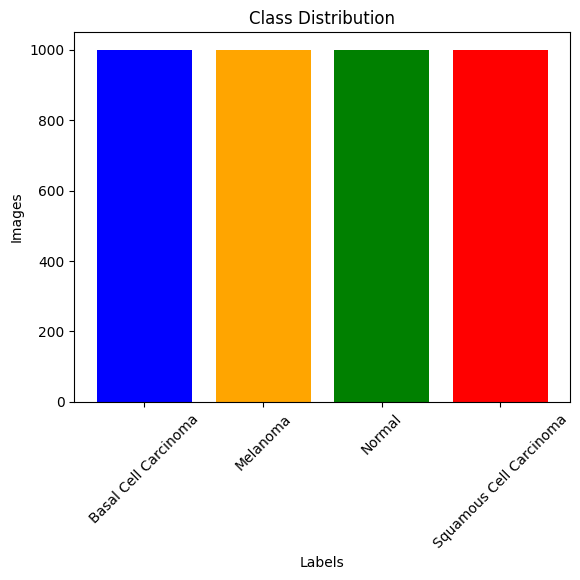

In [20]:
import matplotlib.pyplot as plt


def distribution_data(directory):
  count = {}
  for label in os.listdir(directory):
    label_path = os.path.join(directory, label)
    count[label] = len(os.listdir(label_path))
  return count


class_distribution = distribution_data(train_data_path)

# DataFrame distributions
df = pd.DataFrame(list(class_distribution.items()), columns=['class', 'count'])
print(df)

plt.bar(class_distribution.keys(), class_distribution.values(),
        color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Labels')
plt.ylabel('Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [21]:
df

,class,count
0,Basal Cell Carcinoma,1000
1,Melanoma,1000
2,Normal,1000
3,Squamous Cell Carcinoma,1000


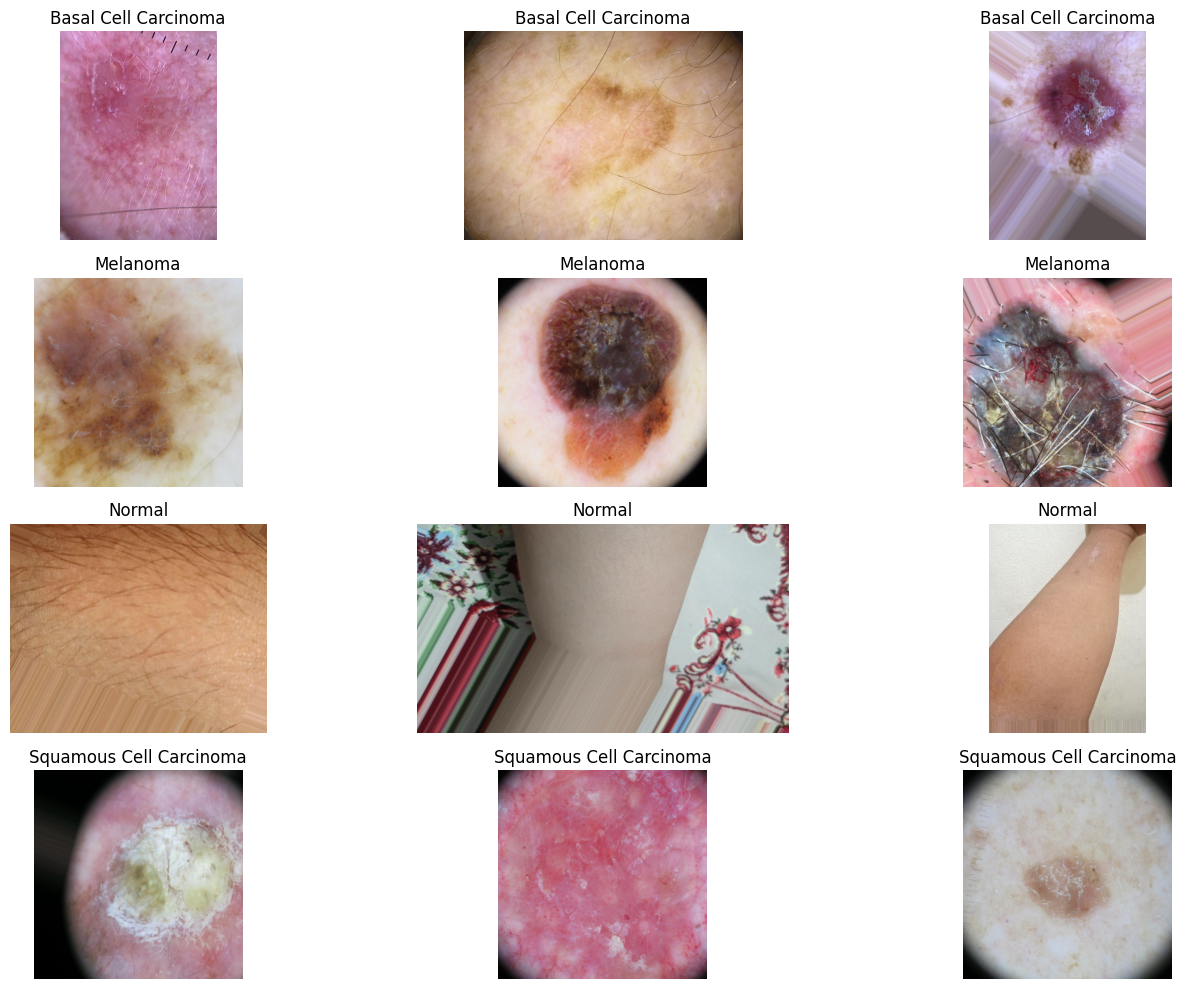

In [22]:
import random

# Visualisasi sampel gambar


def plot_sample_images(directory, classes, num_samples=3):
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 10))
    for i, cls in enumerate(classes):
        cls_path = os.path.join(directory, cls)
        samples = random.sample(os.listdir(cls_path), num_samples)
        for j, sample in enumerate(samples):
            img_path = os.path.join(cls_path, sample)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(cls)
    plt.tight_layout()
    plt.show()


plot_sample_images(train_data_path, list(class_distribution.keys()))

### Split data

In [36]:
train_gen = tf.keras.utils.image_dataset_from_directory(
    train_data_path,
    labels='inferred',          # Label diambil dari struktur folder
    label_mode='categorical',   # Multi-class classification
    image_size=(224, 224),      # Resize gambar ke 224x224
    batch_size=32,              # Batch size
    shuffle=True                # Acak data di train
)

val_gen = tf.keras.utils.image_dataset_from_directory(
    val_data_path,
    labels='inferred',          # Label diambil dari struktur folder
    label_mode='categorical',   # Multi-class classification
    image_size=(224, 224),      # Resize gambar ke 224x224
    batch_size=32,              # Batch size
    shuffle=False                # Acak data di train
)

Found 4000 files belonging to 4 classes.
Found 1200 files belonging to 4 classes.


## Build model

In [37]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                           input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Regularization
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Regularization
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 classes
])

optimizer_adam = Adam(learning_rate=1e-4)

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 128)      

In [39]:
optimizer_adam = Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer_adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [40]:
# Train Model
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),   # Total batch di train_gen
    epochs=50,
    validation_data=val_gen,
    validation_steps=len(val_gen),    # Total batch di val_gen
    verbose=2
)

Epoch 1/50


125/125 - 133s - loss: 1.8131 - accuracy: 0.3280 - val_loss: 1.1455 - val_accuracy: 0.5167 - 133s/epoch - 1s/step
Epoch 2/50
125/125 - 125s - loss: 1.1650 - accuracy: 0.4848 - val_loss: 0.9552 - val_accuracy: 0.5858 - 125s/epoch - 998ms/step
Epoch 3/50
125/125 - 170s - loss: 1.0798 - accuracy: 0.5325 - val_loss: 0.9516 - val_accuracy: 0.5633 - 170s/epoch - 1s/step
Epoch 4/50
125/125 - 159s - loss: 0.9738 - accuracy: 0.5732 - val_loss: 0.9489 - val_accuracy: 0.5892 - 159s/epoch - 1s/step
Epoch 5/50
125/125 - 159s - loss: 0.9108 - accuracy: 0.6047 - val_loss: 0.8784 - val_accuracy: 0.6283 - 159s/epoch - 1s/step
Epoch 6/50
125/125 - 153s - loss: 0.8668 - accuracy: 0.6185 - val_loss: 0.8902 - val_accuracy: 0.6133 - 153s/epoch - 1s/step
Epoch 7/50
125/125 - 149s - loss: 0.8426 - accuracy: 0.6300 - val_loss: 0.7764 - val_accuracy: 0.6617 - 149s/epoch - 1s/step
Epoch 8/50
125/125 - 161s - loss: 0.7822 - accuracy: 0.6550 - val_loss: 0.8779 - val_accuracy: 0.6550 - 161s/epoch - 1s/

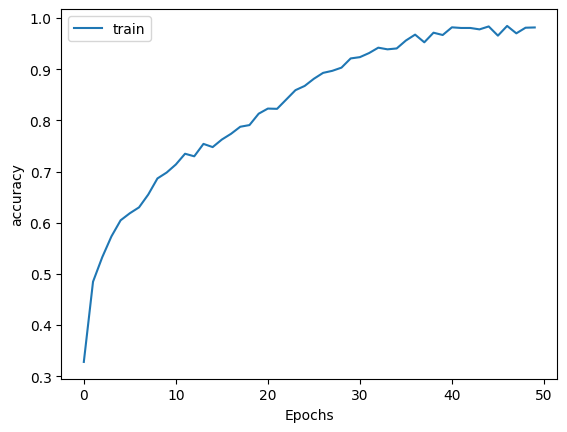

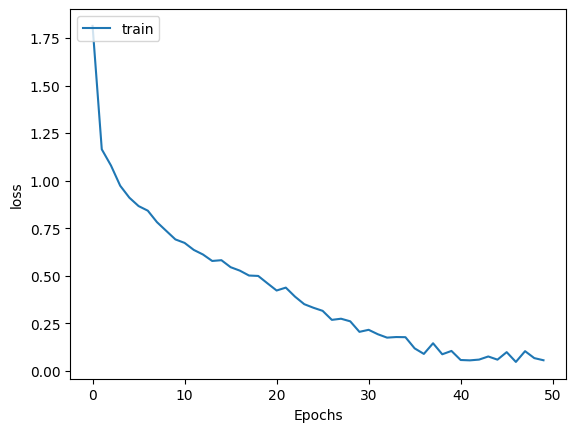

In [43]:
def PlotHistModel(hist, typePlt):
    plt.plot(hist.history[typePlt])
    plt.ylabel(typePlt)
    plt.xlabel('Epochs')
    plt.legend(['train'], loc='upper left')
    plt.show()


PlotHistModel(history, 'accuracy')
PlotHistModel(history, 'loss')

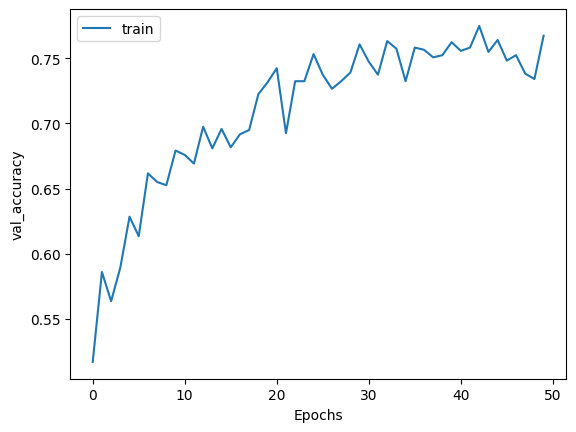

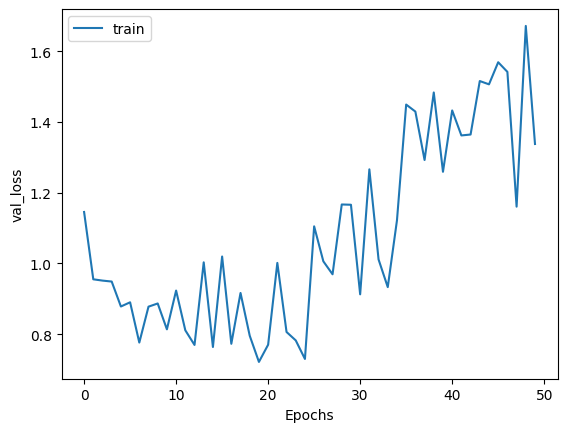

In [45]:
def PlotHistModel(hist, typePlt):
    plt.plot(hist.history[typePlt])
    plt.ylabel(typePlt)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


# Mengganti 'accuracy' dan 'loss' dengan 'val_accuracy' dan 'val_loss'
PlotHistModel(history, 'val_accuracy')
PlotHistModel(history, 'val_loss')

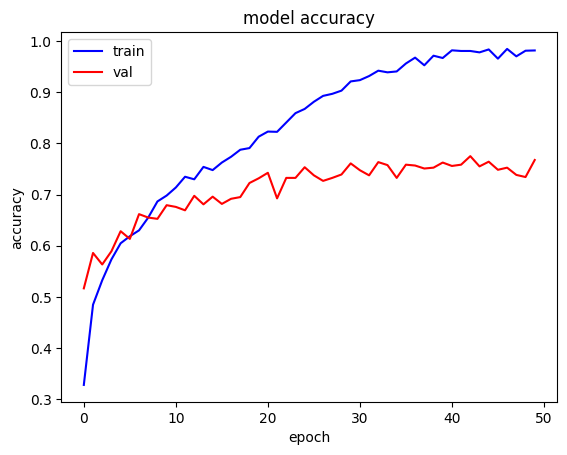

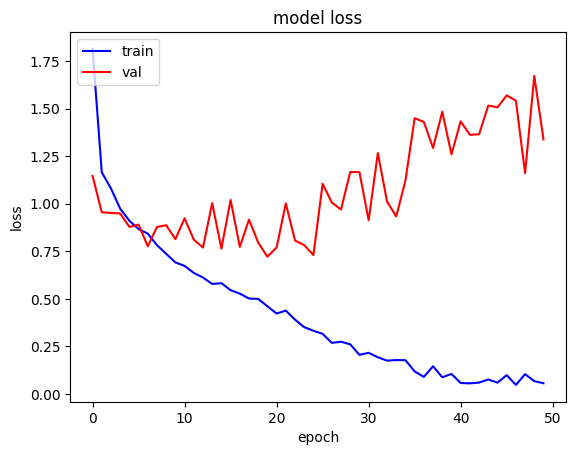

In [47]:
# Plot akurasi dan loss model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc, color='blue')
plt.plot(val_acc, color='red')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(loss, color='blue')
plt.plot(val_loss, color='red')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()